<a id='top'> </a>

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-07-11 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.6.0


# Compositon dependence of CR anisotropy
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
2. [Projected relative intensity](#Projected-relative-intensity)
3. [Cross-check: random splitting of events](#Cross-check:-random-splitting-of-events)

In [2]:
%matplotlib inline
from __future__ import division, print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns
import healpy as hp
from sklearn.model_selection import KFold
import multiprocessing as mp

from icecube import astro

import comptools as comp
import comptools.analysis.plotting as plotting
import comptools.anisotropy.anisotropy as anisotropy

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# config = ['IC86.2012', 'IC86.2013', 'IC86.2014']
config = ['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']
n_side = 64
smooth_rad = 20.0
scale = 3
decmax = -55
years_str = '2011-2015'
composition='all'
low_energy = True

In [43]:
kwargs_data = {'config': config, 'low_energy': low_energy, 'smooth': False, 'scale': False, 'decmax': decmax}

In [4]:
n_total = anisotropy.get_num_events(config=config, composition='all', decmax=decmax)
n_light = anisotropy.get_num_events(config=config, composition='light', decmax=decmax)
n_heavy = anisotropy.get_num_events(config=config, composition='heavy', decmax=decmax)

NameError: name 'anisotropy' is not defined

In [ ]:
n_light/n_total, n_heavy/n_total

In [ ]:
data_heavy = anisotropy.get_map('data', composition='heavy', **kwargs_data)
data_heavy[ data_heavy < 0 ] = 0
'{:g}'.format(data_heavy.sum())

In [5]:
kwargs_relint = {'config': config, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': scale, 'decmax': decmax}

In [6]:
relint_all = anisotropy.get_map(name='relint', composition='all', **kwargs_relint)
relint_light = anisotropy.get_map(name='relint', composition='light', **kwargs_relint)
relint_heavy = anisotropy.get_map(name='relint', composition='heavy', **kwargs_relint)

2.08325176353
-3.60929347976


/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/healpy/projector.py:750: RuntimeWarning: invalid value encountered in greater
  mask = (np.asarray(x)**2+np.asarray(y)**2>1.0)
/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


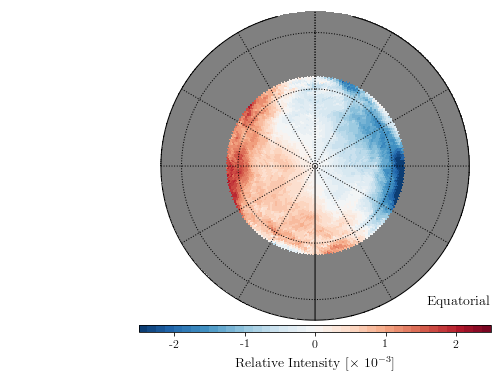

In [7]:
print(relint_all.max())
print(relint_all[relint_all != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_all, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2011-2015', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'all', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

3.64141176417
-3.3694303342


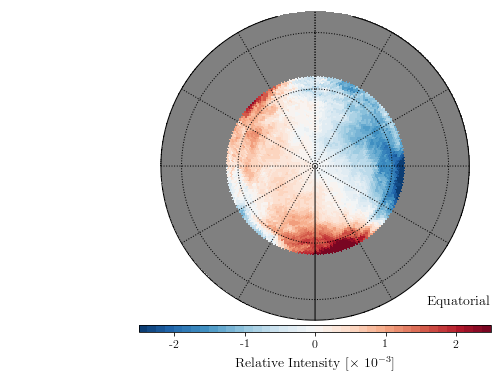

In [8]:
print(relint_light.max())
print(relint_light[relint_light != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_light, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2011-2015', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'light', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

2.11580412194
-2.75739852634


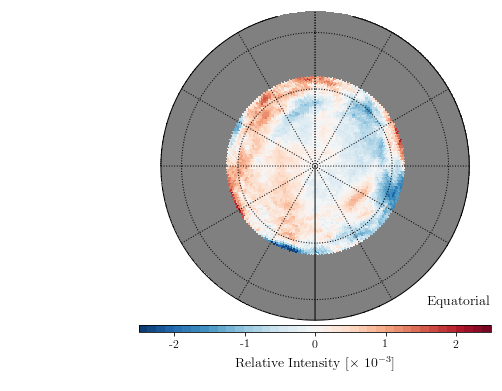

In [9]:
print(relint_heavy.max())
print(relint_heavy[relint_heavy != hp.UNSEEN].min())
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(relint_heavy, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2011-2015', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'heavy', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

In [79]:
kwargs_sig = {'config': config, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': None, 'decmax': decmax}

In [80]:
sig_all = anisotropy.get_map(name='sig', composition='all', **kwargs_sig)
sig_light = anisotropy.get_map(name='sig', composition='light', **kwargs_sig)
sig_heavy = anisotropy.get_map(name='sig', composition='heavy', **kwargs_sig)

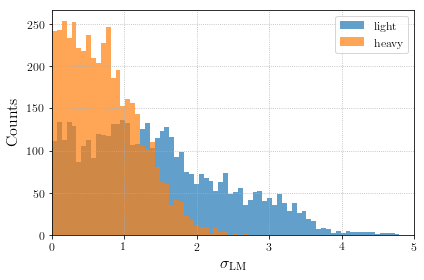

In [83]:
fig, ax = plt.subplots()
bins = np.linspace(0, 5, 75)
# bins = np.linspace(-5, 5, 75)
ax.hist(np.abs(sig_light)[sig_light != hp.UNSEEN], bins=bins, alpha=0.7, label='light')
ax.hist(np.abs(sig_heavy)[(sig_heavy != hp.UNSEEN) & ~np.isnan(sig_heavy)], bins=bins, alpha=0.7, label='heavy')
ax.set_xlabel('$\mathrm{\sigma_{LM}}$')
ax.set_ylabel('Counts')
ax.set_xlim(0, 5)
ax.legend()
ax.grid()
# outfile = 'IC86-{}_sig_dist_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
# plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

On ['IC86.2011']...
On ['IC86.2011', 'IC86.2012']...
On ['IC86.2011', 'IC86.2012', 'IC86.2013']...
On ['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014']...


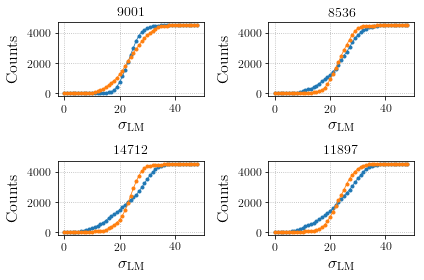

In [87]:
fig, axarr = plt.subplots(2, 2)
for c, ax in zip([['IC86.2011'], ['IC86.2011', 'IC86.2012'], ['IC86.2011', 'IC86.2012', 'IC86.2013'],
                  ['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014']], axarr.flatten()):
    print('On {}...'.format(c))
    
    kwargs_sig = {'config': c, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': None, 'decmax': decmax}
    
    sig_all = anisotropy.get_map(name='sig', composition='all', **kwargs_sig)
    sig_light = anisotropy.get_map(name='sig', composition='light', **kwargs_sig)
    sig_heavy = anisotropy.get_map(name='sig', composition='heavy', **kwargs_sig)

    # bins = np.linspace(0, 5, 50)
    bins = np.linspace(-5, 5, 50)
    # Construct masks
    is_good_mask_light = (sig_light != hp.UNSEEN) & ~np.isnan(sig_light)
    is_good_mask_heavy = (sig_heavy != hp.UNSEEN) & ~np.isnan(sig_heavy)

    counts_light = np.histogram(sig_light[is_good_mask_light], bins=bins)[0]
    counts_heavy = np.histogram(sig_heavy[is_good_mask_heavy], bins=bins)[0]

    # counts_light = np.histogram(np.abs(sig_light[is_good_mask_light]), bins=bins)[0]
    # counts_heavy = np.histogram(np.abs(sig_heavy[is_good_mask_heavy]), bins=bins)[0]

    ax.plot(np.cumsum(counts_light))
    ax.plot(np.cumsum(counts_heavy))

    ax.set_title(np.abs(np.cumsum(counts_light) - np.cumsum(counts_heavy)).sum())

    ax.set_xlabel('$\mathrm{\sigma_{LM}}$')
    ax.set_ylabel('Counts')
    # ax.set_xlim(0, 5)
    ax.legend()
    ax.grid()
# outfile = 'IC86-{}_sig_dist_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
# plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

In [27]:
from scipy.stats import ks_2samp
ks_statistic, pval = ks_2samp(sig_light[sig_light != hp.UNSEEN],
                              sig_heavy[(sig_heavy != hp.UNSEEN) & ~np.isnan(sig_heavy)])

In [28]:
ks_statistic, pval

(0.20742892472458974, 3.6566208592058602e-85)

4.01250851685
-5.76816266373


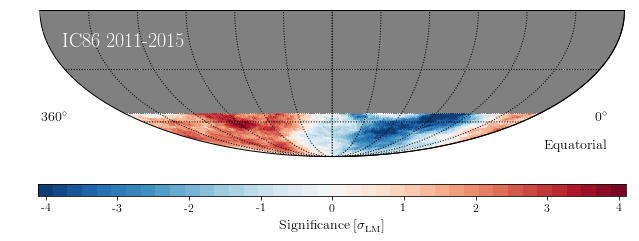

In [51]:
print(sig_all.max())
print(sig_all[sig_all != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_all, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2011-2015', 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=False)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'all', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

5.06572208224
-4.37326994469


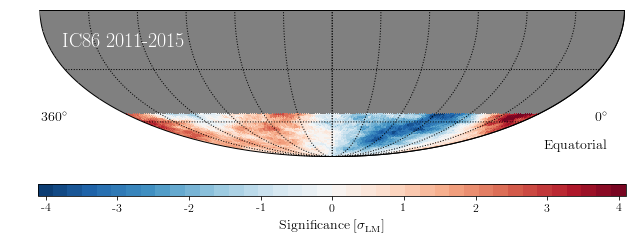

In [52]:
print(sig_light.max())
print(sig_light[sig_light != hp.UNSEEN].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_light, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2011-2015', 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=False)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'light', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

In [53]:
sig_heavy

array([ -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30, ...,
        -4.43908691e-02,   3.34463131e-02,   2.35140359e-02])

2.15891044549
-2.66076693744


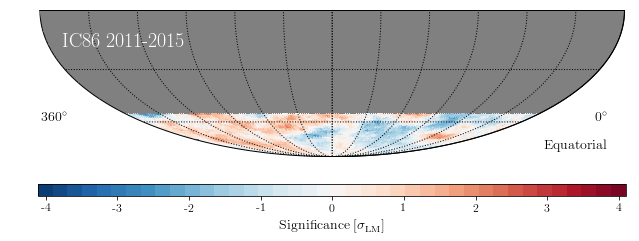

In [54]:
print(sig_heavy[(sig_heavy != hp.UNSEEN) & ~np.isnan(sig_heavy)].max())
print(sig_heavy[(sig_heavy != hp.UNSEEN) & ~np.isnan(sig_heavy)].min())
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_heavy, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2011-2015', 
                                 cbar_title=title, cbar_min=-4.1, cbar_max=4.1, polar=False)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'heavy', n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

In [30]:
rel_int_diff = anisotropy.get_relint_diff(**kwargs_relint)
print(rel_int_diff.max())
print(rel_int_diff[rel_int_diff != hp.UNSEEN].min())

2.38421078863
-2.57748060774


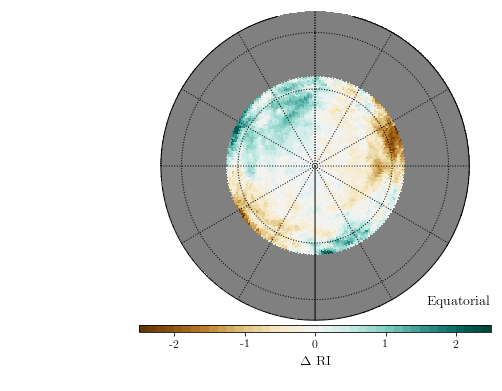

In [31]:
title = '$\mathrm{\Delta \ RI}$'
fig, ax = anisotropy.plot_skymap(rel_int_diff, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='BrBG', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_RI-diff_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))

# Projected relative intensity
[ [back to top](#top) ]

In [62]:
config = ['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']
years_str = '2011-2015'
n_bins = 24
kwargs_relint = {'config': config, 'low_energy': low_energy, 'smooth': smooth_rad, 'scale': None, 'decmax': decmax}

In [63]:
n_total = anisotropy.get_num_events(config=config, composition='all', decmax=decmax, low_energy=low_energy)
n_light = anisotropy.get_num_events(config=config, composition='light', decmax=decmax, low_energy=low_energy)
n_heavy = anisotropy.get_num_events(config=config, composition='heavy', decmax=decmax, low_energy=low_energy)

In [64]:
print(n_light/n_total)
print(n_heavy/n_total)

0.619571969582
0.380427881947


In [65]:
relint_all = anisotropy.get_map(name='relint', composition='all', **kwargs_relint)
relint_all_err = anisotropy.get_map(name='relerr', composition='all', **kwargs_relint)

In [66]:
ri_all, ri_all_err, ra, ra_err = anisotropy.get_proj_relint(relint_all, relint_all_err, n_bins=n_bins)

In [67]:
popt_all, perr_all, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_all, sigmay=ri_all_err, l=3)

amp_all = popt_all[1]
amp_err_all = perr_all[1]

phase_all = np.rad2deg(popt_all[2])
phase_err_all = np.rad2deg(perr_all[2])

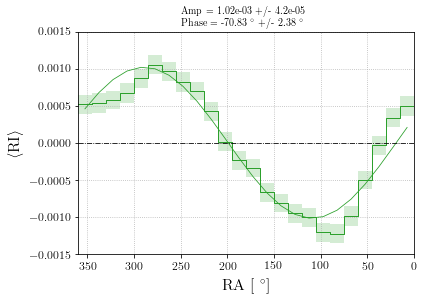

In [68]:
fig, ax = plt.subplots()
# ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', c='C2', label='all')
ra_bins = np.linspace(0, 360, n_bins + 1)
plotting.plot_steps(ra_bins, ri_all, yerr=ri_all_err, color='C2', label='all', fillalpha=0.2, ax=ax)
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_all[:3]), color='C2', marker='None')

ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.grid()
ax.set_ylim(-1.5e-3, 1.5e-3)
ax.set_xlim(0, 360)
ax.invert_xaxis()
# ax.legend()

all_amp_str = 'Amp = {:0.2e} +/- {:0.1e}'.format(amp_all, amp_err_all)
all_phase_str = 'Phase = {:0.2f} {} +/- {:0.2f} {}'.format(phase_all, '$^{\circ}$', phase_err_all, '$^{\circ}$')
ax.text(250, 1.575e-3, all_amp_str + '\n' + all_phase_str)

outfile = 'IC86-{}_proj-RI-all_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

In [69]:
relint_light = anisotropy.get_map(name='relint', composition='light', **kwargs_relint)
relint_light_err = anisotropy.get_map(name='relerr', composition='light', **kwargs_relint)
ri_light, ri_light_err, ra, ra_err = anisotropy.get_proj_relint(relint_light, relint_light_err, n_bins=n_bins)

In [70]:
relint_heavy = anisotropy.get_map(name='relint', composition='heavy', **kwargs_relint)
relint_heavy_err = anisotropy.get_map(name='relerr', composition='heavy', **kwargs_relint)
ri_heavy, ri_heavy_err, ra, ra_err = anisotropy.get_proj_relint(relint_heavy, relint_heavy_err, n_bins=n_bins)

In [71]:
popt_light, perr_light, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_light, sigmay=ri_light_err, l=3)
popt_heavy, perr_heavy, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_heavy, sigmay=ri_heavy_err, l=3)

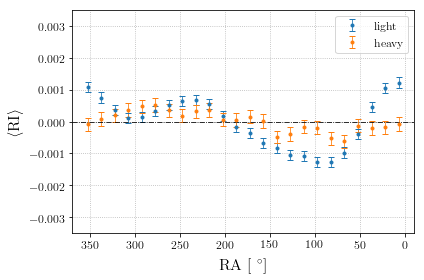

In [72]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-3.5e-3, 3.5e-3)
outfile = 'IC86-{}_proj-RI-comps_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

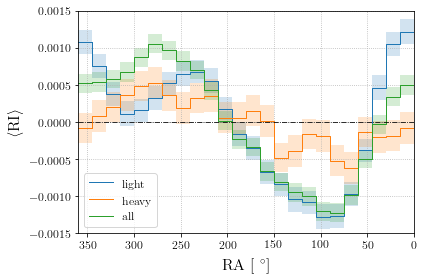

In [73]:
fig, ax = plt.subplots()
# ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
plotting.plot_steps(ra_bins, ri_light, yerr=ri_light_err, color='C0', label='light', fillalpha=0.2, ax=ax)

# ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
plotting.plot_steps(ra_bins, ri_heavy, yerr=ri_heavy_err, color='C1', label='heavy', fillalpha=0.2, ax=ax)

# ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
plotting.plot_steps(ra_bins, ri_all, yerr=ri_all_err, color='C2', label='all', fillalpha=0.2, ax=ax)

ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.set_ylim(-1.5e-3, 1.5e-3)
ax.set_xlim(0, 360)
ax.invert_xaxis()

outfile = 'IC86-{}_proj-RI_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

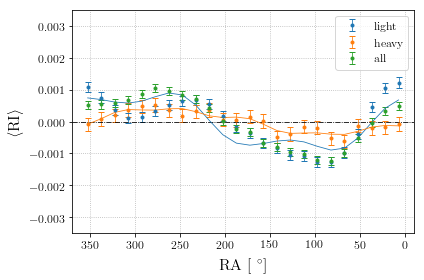

In [30]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_light), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_heavy), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-3.5e-3, 3.5e-3)
outfile = 'IC86-{}_proj-RI-fit_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

In [31]:
amp_light = popt_light[1]
amp_heavy = popt_heavy[1]
amp_err_light = perr_light[1]
amp_err_heavy = perr_heavy[1]

phase_light = np.rad2deg(popt_light[2])
phase_heavy = np.rad2deg(popt_heavy[2])
phase_err_light = np.rad2deg(perr_light[2])
phase_err_heavy = np.rad2deg(perr_heavy[2])

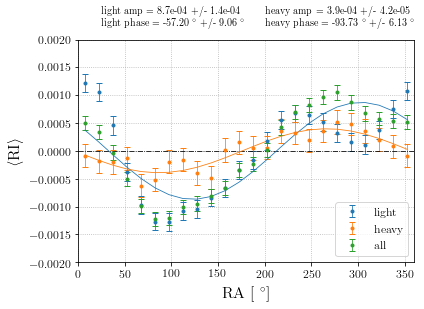

In [42]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_light, yerr=ri_light_err, marker='.', ls='None', label='light')
ax.errorbar(ra, ri_heavy, yerr=ri_heavy_err, marker='.', ls='None', label='heavy')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_light[:3]), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_heavy[:3]), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
# ax.invert_xaxis()
ax.set_ylim(-2e-3, 2e-3)
# ax.set_ylim(-3.5e-3, 3.5e-3)
ax.set_xlim(0, 360)

light_amp_str = 'light amp = {:0.1e} +/- {:0.1e}'.format(amp_light, amp_err_light)
light_phase_str = 'light phase = {:0.2f} {} +/- {:0.2f} {}'.format(phase_light, '$^{\circ}$', phase_err_light, '$^{\circ}$')
ax.text(25, 2.25e-3, light_amp_str + '\n' + light_phase_str)
# ax.text(350, 0.00225, light_amp_str + '\n' + light_phase_str)

heavy_amp_str = 'heavy amp = {:0.1e} +/- {:0.1e}'.format(amp_heavy, amp_err_heavy)
heavy_phase_str = 'heavy phase = {:0.2f} {} +/- {:0.2f} {}'.format(phase_heavy, '$^{\circ}$', phase_err_heavy, '$^{\circ}$')
ax.text(200, 2.25e-3, heavy_amp_str + '\n' + heavy_phase_str)
# ax.text(175, 0.00225, heavy_amp_str + '\n' + heavy_phase_str)

outfile = 'IC86-{}_proj-RI-dipolefit_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(comp.paths.figures_dir, outfile))
plt.show()

# Cross-check: random splitting of events
[ [back to top](#top) ]

In [66]:
config = ['IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']
n_side = 64
smooth_rad = 20.0
scale = 3
decmax = -55
figures_dir = '/home/jbourbeau/public_html/figures/composition-anisotropy/cross-check-random-split'
years_str = '2012-2015'

In [67]:
rel_int_0 = anisotropy.get_map('relint', config=config, composition='random_0',
                             smooth=smooth_rad, scale=scale, decmax=decmax)
rel_int_1 = anisotropy.get_map('relint', config=config, composition='random_1',
                             smooth=smooth_rad, scale=scale, decmax=decmax)
print(rel_int_0.max())
print(rel_int_0[rel_int_0 != hp.UNSEEN].min())

print(rel_int_1.max())
print(rel_int_1[rel_int_1 != hp.UNSEEN].min())

2.65429851244
-3.36021713829
2.58918508496
-3.14294109658


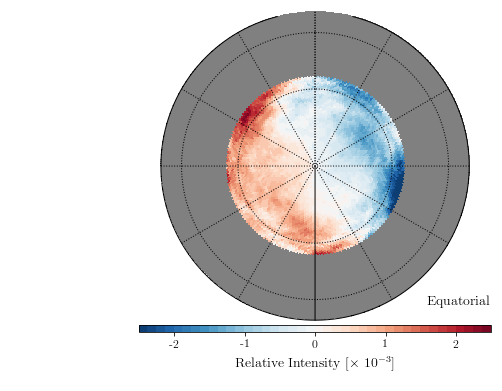

In [68]:
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(rel_int_0, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_0', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

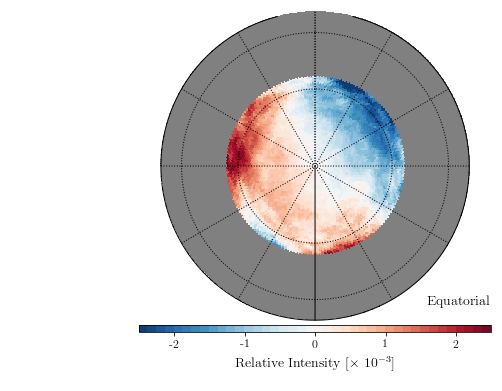

In [69]:
title = 'Relative Intensity [$\\times \ 10^{}$]'.format('{'+str(-scale)+'}')
fig, ax = anisotropy.plot_skymap(rel_int_1, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-2.5, cbar_max=2.5, polar=True)
outfile = 'IC86-{}_relint_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_1', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

In [70]:
sig_0 = anisotropy.get_map('sig', composition='random_0', config=config, smooth=smooth_rad, decmax=decmax)
sig_1 = anisotropy.get_map('sig', composition='random_1', config=config, smooth=smooth_rad, decmax=decmax)

In [71]:
print(sig_0.max())
print(sig_0[sig_0 != hp.UNSEEN].min())

print(sig_1.max())
print(sig_1[sig_1 != hp.UNSEEN].min())

3.10673742569
-3.66635747678
3.68417830318
-3.60931721794


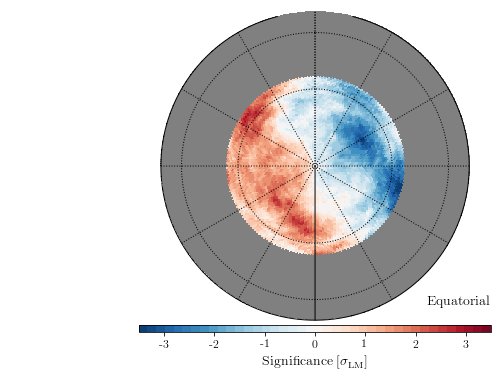

In [72]:
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_0, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-3.5, cbar_max=3.5, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_0', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

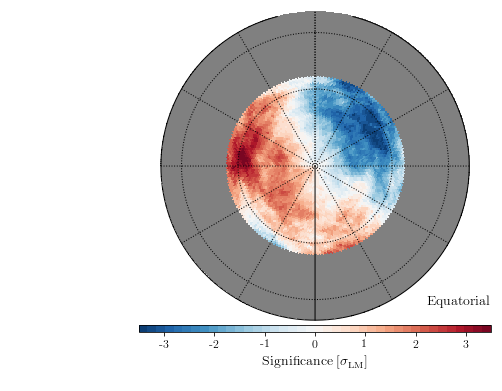

In [73]:
title = 'Significance [$\mathrm{\sigma_{LM}}$]'
fig, ax = anisotropy.plot_skymap(sig_1, smooth=smooth_rad, decmax=decmax, scale=scale,
                                 color_palette='RdBu_r', symmetric=True, llabel='IC86 2012-2013', 
                                 cbar_title=title, cbar_min=-3.5, cbar_max=3.5, polar=True)
outfile = 'IC86-{}_sig_{}_nside-{}_smooth-{:0.1f}.png'.format(years_str, 'random_1', n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))

In [74]:
relint = anisotropy.get_map('relint', config=config, composition='all',
                             smooth=smooth_rad, scale=None, decmax=decmax)
relint_err = anisotropy.get_map('relerr', config=config, composition='all',
                             smooth=smooth_rad, scale=None, decmax=decmax)

In [75]:
ri_all, ri_all_err, ra, ra_err = anisotropy.get_proj_relint(relint, relint_err)

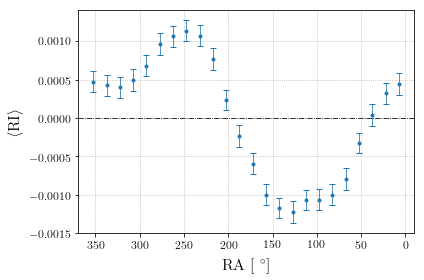

In [76]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.grid()
ax.invert_xaxis()
plt.show()

In [91]:
relint_0 = anisotropy.get_map('relint', config=config, composition='random_0',
                             smooth=smooth_rad, scale=None, decmax=decmax)
relint_err_0 = anisotropy.get_map('relerr', config=config, composition='random_0',
                             smooth=smooth_rad, scale=None, decmax=decmax)
ri_0, ri_err_0, ra, ra_err = anisotropy.get_proj_relint(relint_0, relint_err_0)

In [92]:
relint_1 = anisotropy.get_map('relint', config=config, composition='random_1',
                             smooth=smooth_rad, scale=None, decmax=decmax)
relint_err_1 = anisotropy.get_map('relerr', config=config, composition='random_1',
                             smooth=smooth_rad, scale=None, decmax=decmax)
ri_1, ri_err_1, ra, ra_err = anisotropy.get_proj_relint(relint_1, relint_err_1)

In [93]:
popt_0, perr, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_0, sigmay=ri_err_0)
popt_1, perr, chi2 = anisotropy.get_proj_fit_params(np.deg2rad(ra), ri_1, sigmay=ri_err_1)

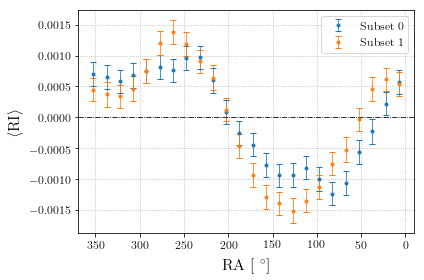

In [94]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
plt.show()

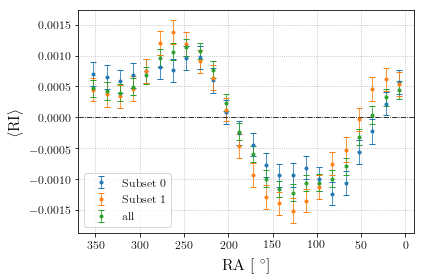

In [95]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
plt.show()

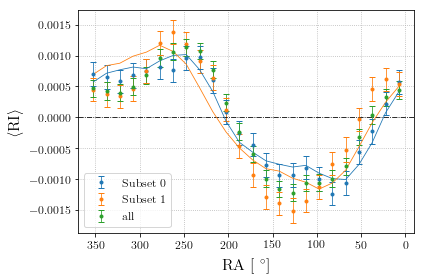

In [96]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_0), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_1), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
plt.show()

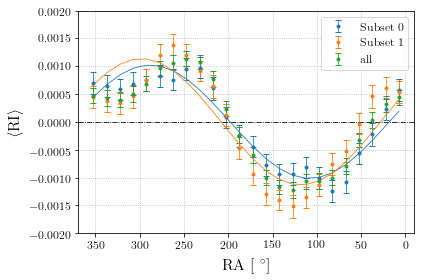

In [97]:
fig, ax = plt.subplots()
ax.errorbar(ra, ri_0, yerr=ri_err_0, marker='.', ls='None', label='Subset 0')
ax.errorbar(ra, ri_1, yerr=ri_err_1, marker='.', ls='None', label='Subset 1')
ax.errorbar(ra, ri_all, yerr=ri_all_err, marker='.', ls='None', label='all')
ax.axhline(0, marker='None', ls='-.', c='k')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_0[:3]), color='C0', marker='None')
ax.plot(ra, anisotropy.cos_fit_func(np.deg2rad(ra), *popt_1[:3]), color='C1', marker='None')
ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
ax.set_xlabel('RA [ $^{\circ}$]')
ax.legend()
ax.grid()
ax.invert_xaxis()
ax.set_ylim(-2e-3, 2e-3)
outfile = 'IC86-{}_proj-RI-dipolefit_random_nside-{}_smooth-{:0.1f}.png'.format(years_str, n_side, smooth_rad)
plt.savefig(os.path.join(figures_dir, outfile))
plt.show()

In [98]:
'{:g}'.format(popt_0[1]), '{:g}'.format(popt_1[1])

('0.0010178', '0.00113404')

In [99]:
np.rad2deg(popt_0[2]), np.rad2deg(popt_1[2])

(-71.862836300904505, -61.870525912281074)

In [3]:
# Load full DataFrame for config
mypaths = comp.get_paths()
df_file = os.path.join(mypaths.comp_data_dir, 'IC86.2013' + '_data',
                       'anisotropy_dataframe.hdf')
with pd.HDFStore(df_file) as store:
    data_df = store['dataframe']

In [6]:
data_df.head()

,lap_zenith,lap_azimuth,start_time_mjd,pred_comp
0,0.206773,5.480972,56414.452644,light
1,0.181282,2.019701,56414.452706,heavy
2,0.220391,3.160242,56414.452744,heavy
3,0.408630,1.879472,56414.452762,light
4,0.061005,1.460350,56414.452762,light


In [5]:
n_side = 64
n_pix = hp.nside2npix(n_side)
bdt_score_skymap = np.zeros(n_pix)

for idx, row in data_df.iterrows():
    
    local_zenith = row['lap_zenith']
    local_azimuth = row['lap_azimuth']
    local_time = row['start_time_mjd']

    ra, dec = astro.dir_to_equa(local_zenith, local_azimuth, local_time)
    hp_theta, hp_phi = anisotropy.equatorial_to_healpy(ra, dec)
    pix = hp.ang2pix(n_side, hp_theta, hp_phi)
    bdt_score_skymap[pix] += row['score']

KeyError: ('lap_zenith', u'occurred at index lap_zenith')

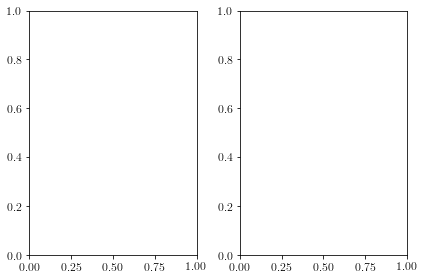

In [80]:
fig, axarr = plt.subplots(1, 2)

In [82]:
ax = axarr[0]

In [ ]:
ax.s